<a href="https://colab.research.google.com/github/Srivishnu27feb/NER-Bi-LSTM/blob/master/Bi_LSTM_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


NER Data is downloaded from kaggle site (https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv)

In [3]:
path = "/content/drive/My Drive/Entity_Extraction_NER/ner_dataset.csv"
NER_data = pd.read_csv(path,encoding = 'unicode_escape')
NER_data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


Creating Vocab list using Dictionary for tokens as well as tags

In [4]:
from itertools import chain

def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(NER_data, 'token')
tag2idx, idx2tag = get_dict_map(NER_data, 'tag')

In [5]:
NER_data['Word_idx'] = NER_data['Word'].map(token2idx)
NER_data['Tag_idx'] = NER_data['Tag'].map(tag2idx)
NER_data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,314,3
1,NaN,of,IN,O,1744,3
2,NaN,demonstrators,NNS,O,13090,3
3,NaN,have,VBP,O,580,3
4,NaN,marched,VBN,O,33030,3


In [6]:
NER_data.isna().any()

Sentence #     True
Word          False
POS           False
Tag           False
Word_idx      False
Tag_idx       False
dtype: bool

In [7]:
NER_data_fillna = NER_data.fillna(method='ffill', axis=0) ## Filling the NA data with the lagged present data

In [8]:
NER_data_fillna.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,314,3
1,Sentence: 1,of,IN,O,1744,3
2,Sentence: 1,demonstrators,NNS,O,13090,3
3,Sentence: 1,have,VBP,O,580,3
4,Sentence: 1,marched,VBN,O,33030,3


In [9]:
#Aggregate the list by each sentence
data_group = NER_data_fillna.groupby(['Sentence #'],as_index=False
                                )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

data_group.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[314, 1744, 13090, 580, 33030, 21120, 4034, 28...","[3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, ..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[30236, 777, 22267, 15525, 33339, 28644, 20488...","[12, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[24802, 10499, 14870, 33665, 5279, 27859, 5230...","[3, 3, 0, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 16,..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[1947, 5475, 15897, 26510, 12798, 22960, 19456...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[32195, 7695, 32245, 15929, 4916, 26998, 18880...","[4, 3, 3, 6, 11, 3, 0, 3, 4, 3, 12, 3, 12, 3, ..."


In [61]:
def data_pad_seq(data_group,NER_data_fillna):
  #Get No of tokens
  #Get No of Tags
  #Get the max length of the sentence in the entire corpus for make sure all the sentence length is of equal length [by padding]
  n_token = len(list(set(NER_data['Word'].to_list())))
  n_tag = len(list(set(NER_data['Tag'].to_list())))
  maxlen = max([len(tokens) for tokens in data_group['Word_idx'].tolist()])


  tokens_pad = pad_sequences(data_group['Word_idx'].tolist(), maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
  tag_pad = pad_sequences(data_group['Tag_idx'].tolist(), maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
  n_tags = len(tag2idx)
  #tag_pad = [to_categorical(i, num_classes=n_tags) for i in tag_pad]
  return (tokens_pad, tag_pad,maxlen)

tokens_pad, tag_pad,maxlen = data_pad_seq(data_group,NER_data_fillna)

In [60]:
tag_pad = pad_sequences(data_group['Tag_idx'].tolist(), maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
tag_pad[0]

array([ 3,  3,  3,  3,  3,  3,  4,  3,  3,  3,  3,  3,  4,  3,  3,  3,  3,
        3, 12,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3], dtype=int32)

In [62]:
# Test train split by 80/20 ratio
#train_tokens, test_tokens, train_tags, test_tags = train_test_split(tokens_pad, tag_pad, test_size=0.1, train_size=0.9, shuffle=False)
train_tokens, test_tokens, train_tags, test_tags = train_test_split(tokens_pad, tag_pad, test_size=0.1, shuffle=False)

In [64]:
#Cross check the length of each sentence and it should have equal (104) length
train_tags[0]

array([ 3,  3,  3,  3,  3,  3,  4,  3,  3,  3,  3,  3,  4,  3,  3,  3,  3,
        3, 12,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3], dtype=int32)

In [65]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [66]:
Vocab = len(list(set(NER_data['Word'].to_list())))
output_dim = 32
n_tags = len(tag2idx)
print('input_dim: ', Vocab, '\noutput_dim: ', output_dim, '\ninput_length: ', maxlen, '\nn_tags: ', n_tags)

input_dim:  35178 
output_dim:  32 
input_length:  104 
n_tags:  17


In [68]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional
word_input = Input(shape=(maxlen,))
model = Embedding(input_dim=Vocab, output_dim=50, input_length=maxlen)(word_input)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)
model = Model(word_input, out)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(train_tokens, train_tags.reshape(*train_tags.shape, 1),
                    batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 249s 6ms/step - loss: 0.0716 - accuracy: 0.9825 - val_loss: 0.0317 - val_accuracy: 0.9910
Epoch 2/5
38846/38846 [==============================] - 248s 6ms/step - loss: 0.0265 - accuracy: 0.9923 - val_loss: 0.0263 - val_accuracy: 0.9924
Epoch 3/5
38846/38846 [==============================] - 246s 6ms/step - loss: 0.0221 - accuracy: 0.9936 - val_loss: 0.0249 - val_accuracy: 0.9926
Epoch 4/5
38846/38846 [==============================] - 246s 6ms/step - loss: 0.0199 - accuracy: 0.9941 - val_loss: 0.0232 - val_accuracy: 0.9931
Epoch 5/5
38846/38846 [==============================] - 243s 6ms/step - loss: 0.0184 - accuracy: 0.9945 - val_loss: 0.0233 - val_accuracy: 0.9930


In [44]:
train_tags[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

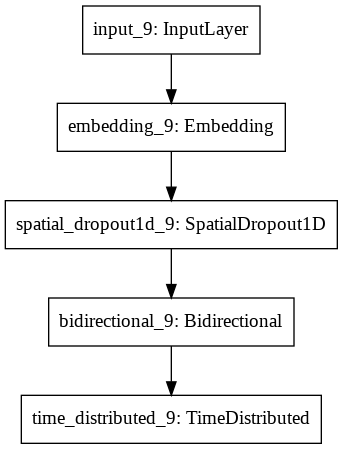

In [79]:
plot_model(model)

In [80]:
i = np.random.randint(0,test_tokens.shape[0])
test_tokens[i]

array([14507, 34024, 11778, 15287, 15236, 13932, 20003, 33387, 16461,
        7268, 20003, 12928, 34679,   672,  6882, 30088, 33453,   580,
       12888, 33032,  8542,   877, 29435, 11400,  2953, 35177, 35177,
       35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
       35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
       35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
       35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
       35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
       35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
       35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
       35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177, 35177,
       35177, 35177, 35177, 35177, 35177], dtype=int32)

In [81]:
p = model.predict(np.array([test_tokens[i]]))

In [82]:
p = np.argmax(p, axis=-1)
true = test_tags[i]

print("Sample number {} of {} (Test Set)".format(i, test_tokens.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(test_tokens[i], true, p[0]):
    if w != 35177:
        print("{:15}: {:5} {}".format(idx2token[w], idx2tag[t], idx2tag[pred]))

Sample number 60 of 4796 (Test Set)
Word           ||True ||Pred
Former         : O     O
CPA            : B-org O
chief          : O     O
Paul           : B-per B-per
Bremer         : I-per I-per
rejected       : O     O
the            : O     O
findings       : O     O
,              : O     O
saying         : O     O
the            : O     O
report         : O     O
assumes        : O     O
western-style  : O     O
accounting     : O     O
procedures     : O     O
could          : O     O
have           : O     O
been           : O     O
quickly        : O     O
set            : O     O
up             : O     O
during         : O     O
wartime        : O     O
.              : O     O
